In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel, BertTokenizer
from torchvision import transforms
from PIL import Image
import json
import os
from typing import Optional, Tuple
import math
from tqdm import tqdm
import time
from datetime import datetime
import csv
import signal
import sys

/Users/jagathkumarreddyk/Documents/GitHub/ICapGPT/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# Vision Transformer (ViT) - Frozen Backbone
# ============================================================================
class VisionTransformer(nn.Module):
    """Frozen ViT-Base/16 for image encoding"""
    def __init__(self, image_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # CLS token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio=4.0)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, embed_dim, H, W)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        
        return x

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [4]:
# ============================================================================
# BLIP Model Components - Shared BERT with Task-Specific Modifications
# ============================================================================

class BERTLayer(nn.Module):
    """Standard BERT layer with self-attention and FFN"""
    def __init__(self, config):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            config.hidden_size, 
            config.num_attention_heads,
            dropout=config.attention_probs_dropout_prob,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
        self.ffn = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.intermediate_size, config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob)
        )
    
    def forward(self, x, attention_mask=None, attn_mask=None):
        # Self-attention
        attn_out, _ = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=~attention_mask.bool() if attention_mask is not None else None
        )
        x = self.norm1(x + attn_out)
        
        # Feed-forward
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x



In [5]:


class BERTLayerWithCrossAttention(nn.Module):
    """BERT layer with additional cross-attention for ITM and LM tasks"""
    def __init__(self, config):
        super().__init__()
        # Self-attention
        self.self_attention = nn.MultiheadAttention(
            config.hidden_size,
            config.num_attention_heads,
            dropout=config.attention_probs_dropout_prob,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
        # Cross-attention
        self.cross_attention = nn.MultiheadAttention(
            config.hidden_size,
            config.num_attention_heads,
            dropout=config.attention_probs_dropout_prob,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
        # Feed-forward
        self.ffn = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.intermediate_size, config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob)
        )
        self.norm3 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    
    def forward(self, x, encoder_hidden_states, attention_mask=None, 
                encoder_attention_mask=None, attn_mask=None):
        # Self-attention
        self_attn_out, _ = self.self_attention(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=~attention_mask.bool() if attention_mask is not None else None
        )
        x = self.norm1(x + self_attn_out)
        
        # Cross-attention to image features
        cross_attn_out, _ = self.cross_attention(
            x, encoder_hidden_states, encoder_hidden_states,
            key_padding_mask=~encoder_attention_mask.bool() if encoder_attention_mask is not None else None
        )
        x = self.norm2(x + cross_attn_out)
        
        # Feed-forward
        ffn_out = self.ffn(x)
        x = self.norm3(x + ffn_out)
        
        return x



In [6]:

class SharedBERTEmbeddings(nn.Module):
    """Shared BERT embeddings initialized from pretrained weights"""
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, 
                                           padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
    
    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        seq_length = input_ids.size(1)
        
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]
        
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        
        word_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        embeddings = word_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings


In [7]:


class BLIPModel(nn.Module):
    """
    BLIP model with proper parameter sharing:
    - Shared BERT embeddings and layers for all three tasks
    - ITC: Self-attention only (encoder) + projection head
    - ITM: Self-attention + cross-attention + binary classifier
    - LM: Causal self-attention + cross-attention + vocab head
    """
    def __init__(self, image_size=384, vit_patch_size=16, vit_dim=768, 
                 bert_model_name='bert-base-uncased', embed_dim=256, 
                 queue_size=57600, momentum=0.995):
        super().__init__()
        
        # Load pretrained BERT config
        bert_config = BertConfig.from_pretrained(bert_model_name)
        self.config = bert_config
        
        # Vision encoder (frozen)
        self.visual_encoder = VisionTransformer(
            image_size=image_size,
            patch_size=vit_patch_size,
            embed_dim=vit_dim
        )
        
        # Freeze vision encoder
        for param in self.visual_encoder.parameters():
            param.requires_grad = False
        
        # Vision projection to match BERT hidden size
        self.vision_proj_bert = nn.Linear(vit_dim, bert_config.hidden_size)
        
        # ===== Shared BERT Components (initialized from pretrained) =====
        pretrained_bert = BertModel.from_pretrained(bert_model_name)
        
        # Shared embeddings
        self.shared_embeddings = SharedBERTEmbeddings(bert_config)
        self.shared_embeddings.word_embeddings.weight.data.copy_(
            pretrained_bert.embeddings.word_embeddings.weight.data
        )
        self.shared_embeddings.position_embeddings.weight.data.copy_(
            pretrained_bert.embeddings.position_embeddings.weight.data
        )
        self.shared_embeddings.token_type_embeddings.weight.data.copy_(
            pretrained_bert.embeddings.token_type_embeddings.weight.data
        )
        self.shared_embeddings.LayerNorm.weight.data.copy_(
            pretrained_bert.embeddings.LayerNorm.weight.data
        )
        self.shared_embeddings.LayerNorm.bias.data.copy_(
            pretrained_bert.embeddings.LayerNorm.bias.data
        )
        
        # ===== Task 1: ITC (Image-Text Contrastive) =====
        # Encoder with self-attention only, no cross-attention
        self.text_encoder = nn.ModuleList([
            BERTLayer(bert_config) for _ in range(bert_config.num_hidden_layers)
        ])
        
        # Initialize from pretrained BERT
        for i, layer in enumerate(self.text_encoder):
            pretrained_layer = pretrained_bert.encoder.layer[i]
            # Copy self-attention weights
            layer.attention.in_proj_weight.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.weight.data,
                    pretrained_layer.attention.self.key.weight.data,
                    pretrained_layer.attention.self.value.weight.data
                ], dim=0)
            )
            layer.attention.in_proj_bias.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.bias.data,
                    pretrained_layer.attention.self.key.bias.data,
                    pretrained_layer.attention.self.value.bias.data
                ], dim=0)
            )
            layer.attention.out_proj.weight.data.copy_(
                pretrained_layer.attention.output.dense.weight.data
            )
            layer.attention.out_proj.bias.data.copy_(
                pretrained_layer.attention.output.dense.bias.data
            )
            # Copy layer norm
            layer.norm1.weight.data.copy_(pretrained_layer.attention.output.LayerNorm.weight.data)
            layer.norm1.bias.data.copy_(pretrained_layer.attention.output.LayerNorm.bias.data)
            # Copy FFN
            layer.ffn[0].weight.data.copy_(pretrained_layer.intermediate.dense.weight.data)
            layer.ffn[0].bias.data.copy_(pretrained_layer.intermediate.dense.bias.data)
            layer.ffn[3].weight.data.copy_(pretrained_layer.output.dense.weight.data)
            layer.ffn[3].bias.data.copy_(pretrained_layer.output.dense.bias.data)
            layer.norm2.weight.data.copy_(pretrained_layer.output.LayerNorm.weight.data)
            layer.norm2.bias.data.copy_(pretrained_layer.output.LayerNorm.bias.data)
        
        self.text_encoder_norm = nn.LayerNorm(bert_config.hidden_size, eps=bert_config.layer_norm_eps)
        
        # Projection heads for contrastive learning
        self.vision_proj = nn.Linear(bert_config.hidden_size, embed_dim)
        self.text_proj = nn.Linear(bert_config.hidden_size, embed_dim)
        
        # ===== Task 2: ITM (Image-Text Matching) =====
        # Encoder with self-attention + cross-attention
        self.text_encoder_itm = nn.ModuleList([
            BERTLayerWithCrossAttention(bert_config) for _ in range(bert_config.num_hidden_layers)
        ])
        
        # Initialize from pretrained BERT (self-attention parts)
        for i, layer in enumerate(self.text_encoder_itm):
            pretrained_layer = pretrained_bert.encoder.layer[i]
            # Self-attention
            layer.self_attention.in_proj_weight.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.weight.data,
                    pretrained_layer.attention.self.key.weight.data,
                    pretrained_layer.attention.self.value.weight.data
                ], dim=0)
            )
            layer.self_attention.in_proj_bias.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.bias.data,
                    pretrained_layer.attention.self.key.bias.data,
                    pretrained_layer.attention.self.value.bias.data
                ], dim=0)
            )
            layer.self_attention.out_proj.weight.data.copy_(
                pretrained_layer.attention.output.dense.weight.data
            )
            layer.self_attention.out_proj.bias.data.copy_(
                pretrained_layer.attention.output.dense.bias.data
            )
            # Cross-attention initialized randomly (no pretrained equivalent)
            nn.init.xavier_uniform_(layer.cross_attention.in_proj_weight)
            nn.init.zeros_(layer.cross_attention.in_proj_bias)
            nn.init.xavier_uniform_(layer.cross_attention.out_proj.weight)
            nn.init.zeros_(layer.cross_attention.out_proj.bias)
            # Layer norms
            layer.norm1.weight.data.copy_(pretrained_layer.attention.output.LayerNorm.weight.data)
            layer.norm1.bias.data.copy_(pretrained_layer.attention.output.LayerNorm.bias.data)
            # FFN
            layer.ffn[0].weight.data.copy_(pretrained_layer.intermediate.dense.weight.data)
            layer.ffn[0].bias.data.copy_(pretrained_layer.intermediate.dense.bias.data)
            layer.ffn[3].weight.data.copy_(pretrained_layer.output.dense.weight.data)
            layer.ffn[3].bias.data.copy_(pretrained_layer.output.dense.bias.data)
            layer.norm3.weight.data.copy_(pretrained_layer.output.LayerNorm.weight.data)
            layer.norm3.bias.data.copy_(pretrained_layer.output.LayerNorm.bias.data)
        
        self.text_encoder_itm_norm = nn.LayerNorm(bert_config.hidden_size, eps=bert_config.layer_norm_eps)
        
        # ITM binary classification head
        self.itm_head = nn.Linear(bert_config.hidden_size, 2)
        
        # ===== Task 3: LM (Language Modeling) =====
        # Decoder with causal self-attention + cross-attention
        self.text_decoder = nn.ModuleList([
            BERTLayerWithCrossAttention(bert_config) for _ in range(bert_config.num_hidden_layers)
        ])
        
        # Initialize from pretrained BERT (same as ITM)
        for i, layer in enumerate(self.text_decoder):
            pretrained_layer = pretrained_bert.encoder.layer[i]
            # Self-attention (will use causal mask during forward)
            layer.self_attention.in_proj_weight.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.weight.data,
                    pretrained_layer.attention.self.key.weight.data,
                    pretrained_layer.attention.self.value.weight.data
                ], dim=0)
            )
            layer.self_attention.in_proj_bias.data.copy_(
                torch.cat([
                    pretrained_layer.attention.self.query.bias.data,
                    pretrained_layer.attention.self.key.bias.data,
                    pretrained_layer.attention.self.value.bias.data
                ], dim=0)
            )
            layer.self_attention.out_proj.weight.data.copy_(
                pretrained_layer.attention.output.dense.weight.data
            )
            layer.self_attention.out_proj.bias.data.copy_(
                pretrained_layer.attention.output.dense.bias.data
            )
            # Cross-attention
            nn.init.xavier_uniform_(layer.cross_attention.in_proj_weight)
            nn.init.zeros_(layer.cross_attention.in_proj_bias)
            nn.init.xavier_uniform_(layer.cross_attention.out_proj.weight)
            nn.init.zeros_(layer.cross_attention.out_proj.bias)
            # Layer norms
            layer.norm1.weight.data.copy_(pretrained_layer.attention.output.LayerNorm.weight.data)
            layer.norm1.bias.data.copy_(pretrained_layer.attention.output.LayerNorm.bias.data)
            # FFN
            layer.ffn[0].weight.data.copy_(pretrained_layer.intermediate.dense.weight.data)
            layer.ffn[0].bias.data.copy_(pretrained_layer.intermediate.dense.bias.data)
            layer.ffn[3].weight.data.copy_(pretrained_layer.output.dense.weight.data)
            layer.ffn[3].bias.data.copy_(pretrained_layer.output.dense.bias.data)
            layer.norm3.weight.data.copy_(pretrained_layer.output.LayerNorm.weight.data)
            layer.norm3.bias.data.copy_(pretrained_layer.output.LayerNorm.bias.data)
        
        self.text_decoder_norm = nn.LayerNorm(bert_config.hidden_size, eps=bert_config.layer_norm_eps)
        
        # LM vocabulary prediction head
        self.lm_head = nn.Linear(bert_config.hidden_size, bert_config.vocab_size, bias=False)
        # Tie weights with embeddings
        self.lm_head.weight = self.shared_embeddings.word_embeddings.weight
        
        # Temperature for contrastive learning
        self.temp = nn.Parameter(torch.ones([]) * 0.07)
        
        # ===== Momentum encoder for queue-based contrastive learning =====
        self.visual_encoder_m = VisionTransformer(
            image_size=image_size,
            patch_size=vit_patch_size,
            embed_dim=vit_dim
        )
        self.vision_proj_bert_m = nn.Linear(vit_dim, bert_config.hidden_size)
        
        self.shared_embeddings_m = SharedBERTEmbeddings(bert_config)
        self.text_encoder_m = nn.ModuleList([
            BERTLayer(bert_config) for _ in range(bert_config.num_hidden_layers)
        ])
        self.text_encoder_norm_m = nn.LayerNorm(bert_config.hidden_size, eps=bert_config.layer_norm_eps)
        
        self.vision_proj_m = nn.Linear(bert_config.hidden_size, embed_dim)
        self.text_proj_m = nn.Linear(bert_config.hidden_size, embed_dim)
        
        # Copy parameters and freeze
        self._copy_params()
        for param in self.visual_encoder_m.parameters():
            param.requires_grad = False
        for param in self.vision_proj_bert_m.parameters():
            param.requires_grad = False
        for param in self.shared_embeddings_m.parameters():
            param.requires_grad = False
        for param in self.text_encoder_m.parameters():
            param.requires_grad = False
        for param in self.text_encoder_norm_m.parameters():
            param.requires_grad = False
        for param in self.vision_proj_m.parameters():
            param.requires_grad = False
        for param in self.text_proj_m.parameters():
            param.requires_grad = False
        
        # Create queue
        self.register_buffer("image_queue", torch.randn(embed_dim, queue_size))
        self.register_buffer("text_queue", torch.randn(embed_dim, queue_size))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
        
        self.image_queue = F.normalize(self.image_queue, dim=0)
        self.text_queue = F.normalize(self.text_queue, dim=0)
        self.queue_size = queue_size
        self.momentum = momentum
        
        del pretrained_bert  # Free memory
        
    def _copy_params(self):
        """Copy parameters to momentum encoder"""
        for param, param_m in zip(self.visual_encoder.parameters(), self.visual_encoder_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.vision_proj_bert.parameters(), self.vision_proj_bert_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.shared_embeddings.parameters(), self.shared_embeddings_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.text_encoder.parameters(), self.text_encoder_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.text_encoder_norm.parameters(), self.text_encoder_norm_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.vision_proj.parameters(), self.vision_proj_m.parameters()):
            param_m.data.copy_(param.data)
        for param, param_m in zip(self.text_proj.parameters(), self.text_proj_m.parameters()):
            param_m.data.copy_(param.data)
            
    @torch.no_grad()
    def _momentum_update(self):
        """Update momentum encoder"""
        for param, param_m in zip(self.visual_encoder.parameters(), self.visual_encoder_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.vision_proj_bert.parameters(), self.vision_proj_bert_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.shared_embeddings.parameters(), self.shared_embeddings_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.text_encoder.parameters(), self.text_encoder_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.text_encoder_norm.parameters(), self.text_encoder_norm_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.vision_proj.parameters(), self.vision_proj_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
        for param, param_m in zip(self.text_proj.parameters(), self.text_proj_m.parameters()):
            param_m.data = param_m.data * self.momentum + param.data * (1. - self.momentum)
            
    @torch.no_grad()
    def _dequeue_and_enqueue(self, image_feat, text_feat):
        batch_size = image_feat.shape[0]
        ptr = int(self.queue_ptr)
        
        if ptr + batch_size > self.queue_size:
            batch_size = self.queue_size - ptr
            image_feat = image_feat[:batch_size]
            text_feat = text_feat[:batch_size]
        
        # Replace oldest embeddings
        self.image_queue[:, ptr:ptr + batch_size] = image_feat.T
        self.text_queue[:, ptr:ptr + batch_size] = text_feat.T
        ptr = (ptr + batch_size) % self.queue_size
        
        self.queue_ptr[0] = ptr
        
    def forward(self, image, text_input_ids, text_attention_mask, 
                decoder_input_ids=None, decoder_attention_mask=None, labels=None):
        """
        Forward pass with three objectives:
        1. Image-Text Contrastive (ITC) - self-attention only
        2. Image-Text Matching (ITM) - self-attention + cross-attention with hard negatives
        3. Language Modeling (LM) - causal self-attention + cross-attention
        """
        batch_size = image.size(0)
        
        # ===== Encode Images =====
        with torch.no_grad():
            image_embeds_vit = self.visual_encoder(image)  # (B, num_patches+1, vit_dim)
        
        # Project to BERT dimension
        image_embeds = self.vision_proj_bert(image_embeds_vit)  # (B, num_patches+1, hidden_size)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image.device)
        
        # ===== Task 1: ITC (Image-Text Contrastive) =====
        # Text encoding with self-attention only (no cross-attention)
        text_embeds_input = self.shared_embeddings(text_input_ids)
        text_output = text_embeds_input
        for layer in self.text_encoder:
            text_output = layer(text_output, text_attention_mask)
        text_output = self.text_encoder_norm(text_output)
        
        # Use [CLS] token representations
        image_feat = F.normalize(self.vision_proj(image_embeds[:, 0, :]), dim=-1)
        text_feat = F.normalize(self.text_proj(text_output[:, 0, :]), dim=-1)
        
        # Get momentum features
        with torch.no_grad():
            self._momentum_update()
            image_embeds_m = self.visual_encoder_m(image)
            image_embeds_m = self.vision_proj_bert_m(image_embeds_m)
            image_feat_m = F.normalize(self.vision_proj_m(image_embeds_m[:, 0, :]), dim=-1)
            
            text_embeds_m = self.shared_embeddings_m(text_input_ids)
            text_output_m = text_embeds_m
            for layer in self.text_encoder_m:
                text_output_m = layer(text_output_m, text_attention_mask)
            text_output_m = self.text_encoder_norm_m(text_output_m)
            text_feat_m = F.normalize(self.text_proj_m(text_output_m[:, 0, :]), dim=-1)
            
            # Concatenate with queue
            image_feat_all = torch.cat([image_feat_m.T, self.image_queue.clone().detach()], dim=1)
            text_feat_all = torch.cat([text_feat_m.T, self.text_queue.clone().detach()], dim=1)
            
            # Create targets
            sim_targets = torch.zeros(batch_size, batch_size + self.queue_size).to(image.device)
            sim_targets.fill_diagonal_(1)
        
        # Compute similarities
        sim_i2t = image_feat @ text_feat_all / self.temp
        sim_t2i = text_feat @ image_feat_all / self.temp
        
        # Contrastive loss
        loss_i2t = -torch.sum(F.log_softmax(sim_i2t, dim=1) * sim_targets, dim=1).mean()
        loss_t2i = -torch.sum(F.log_softmax(sim_t2i, dim=1) * sim_targets, dim=1).mean()
        loss_itc = (loss_i2t + loss_t2i) / 2
        
        # Update queue
        self._dequeue_and_enqueue(image_feat_m, text_feat_m)
        
        # ===== Task 2: ITM (Image-Text Matching) with Hard Negatives =====
        # Sample hard negatives based on similarity
        with torch.no_grad():
            weights_i2t = F.softmax(sim_i2t[:, :batch_size], dim=1) + 1e-5
            weights_t2i = F.softmax(sim_t2i[:, :batch_size], dim=1) + 1e-5
            
            # Mask out positives
            weights_i2t.fill_diagonal_(0)
            weights_t2i.fill_diagonal_(0)
        
        # Sample negative images and texts
        image_embeds_neg = []
        text_embeds_neg = []
        text_atts_neg = []
        
        for b in range(batch_size):
            # Sample hard negative image
            neg_idx = torch.multinomial(weights_t2i[b], 1).item()
            image_embeds_neg.append(image_embeds[neg_idx])
            
            # Sample hard negative text
            neg_idx = torch.multinomial(weights_i2t[b], 1).item()
            text_embeds_neg.append(text_input_ids[neg_idx])
            text_atts_neg.append(text_attention_mask[neg_idx])
        
        image_embeds_neg = torch.stack(image_embeds_neg, dim=0)
        text_embeds_neg = torch.stack(text_embeds_neg, dim=0)
        text_atts_neg = torch.stack(text_atts_neg, dim=0)
        
        # Create positive and negative pairs
        # Positive: original pairs
        # Negative: (image, neg_text) and (neg_image, text)
        text_embeds_all = torch.cat([text_input_ids, text_embeds_neg, text_input_ids], dim=0)
        text_atts_all = torch.cat([text_attention_mask, text_atts_neg, text_attention_mask], dim=0)
        image_embeds_all = torch.cat([image_embeds, image_embeds, image_embeds_neg], dim=0)
        image_atts_all = torch.cat([image_atts, image_atts, image_atts], dim=0)
        
        # Forward through ITM encoder (self + cross attention)
        text_embeds_itm = self.shared_embeddings(text_embeds_all)
        output_itm = text_embeds_itm
        for layer in self.text_encoder_itm:
            output_itm = layer(output_itm, image_embeds_all, text_atts_all, image_atts_all)
        output_itm = self.text_encoder_itm_norm(output_itm)
        
        # ITM prediction
        itm_logits = self.itm_head(output_itm[:, 0, :])  # Use [CLS] token
        
        # Create labels: positive=1, negative=0
        itm_labels = torch.cat([
            torch.ones(batch_size, dtype=torch.long),   # Positive pairs
            torch.zeros(batch_size, dtype=torch.long),  # Negative (image, neg_text)
            torch.zeros(batch_size, dtype=torch.long)   # Negative (neg_image, text)
        ], dim=0).to(image.device)
        
        loss_itm = F.cross_entropy(itm_logits, itm_labels)
        
        # ===== Task 3: LM (Language Modeling with Causal Attention) =====
        if decoder_input_ids is not None and labels is not None:
            # Create causal mask
            seq_length = decoder_input_ids.size(1)
            causal_mask = torch.triu(
                torch.ones(seq_length, seq_length, device=image.device) * float('-inf'),
                diagonal=1
            )
            
            # Forward through decoder
            decoder_embeds = self.shared_embeddings(decoder_input_ids)
            decoder_output = decoder_embeds
            for layer in self.text_decoder:
                decoder_output = layer(
                    decoder_output, 
                    image_embeds,
                    decoder_attention_mask, 
                    image_atts,
                    attn_mask=causal_mask
                )
            decoder_output = self.text_decoder_norm(decoder_output)
            
            # Predict next tokens
            lm_logits = self.lm_head(decoder_output)
            
            # Language modeling loss
            loss_lm = F.cross_entropy(
                lm_logits.view(-1, self.config.vocab_size),
                labels.view(-1),
                ignore_index=-100
            )
        else:
            loss_lm = torch.tensor(0.0).to(image.device)
            
        return loss_itc, loss_itm, loss_lm
    
    @torch.no_grad()
    def generate(self, image, tokenizer, max_length=30, num_beams=1):
        """Generate captions using greedy or beam search"""
        self.eval()
        
        # Encode image
        image_embeds_vit = self.visual_encoder(image)
        image_embeds = self.vision_proj_bert(image_embeds_vit)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image.device)
        
        batch_size = image.size(0)
        device = image.device
        
        # Start with [CLS] token
        input_ids = torch.full(
            (batch_size, 1),
            tokenizer.cls_token_id,
            dtype=torch.long
        ).to(device)
        
        # Simple greedy decoding
        for _ in range(max_length - 1):
            attention_mask = torch.ones_like(input_ids)
            seq_length = input_ids.size(1)
            
            # Create causal mask
            causal_mask = torch.triu(
                torch.ones(seq_length, seq_length, device=device) * float('-inf'),
                diagonal=1
            )
            
            # Forward through decoder
            decoder_embeds = self.shared_embeddings(input_ids)
            decoder_output = decoder_embeds
            for layer in self.text_decoder:
                decoder_output = layer(
                    decoder_output,
                    image_embeds,
                    attention_mask,
                    image_atts,
                    attn_mask=causal_mask
                )
            decoder_output = self.text_decoder_norm(decoder_output)
            
            # Predict next token
            logits = self.lm_head(decoder_output[:, -1, :])
            next_token = logits.argmax(dim=-1, keepdim=True)
            
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # Stop if all sequences generated [SEP]
            if (next_token == tokenizer.sep_token_id).all():
                break
                
        return input_ids



In [8]:
# ============================================================================
# Dataset
# ============================================================================
class COCOCaptionDataset(Dataset):
    """COCO Captions Dataset"""
    def __init__(self, json_path, image_root, transform, tokenizer, max_length=30):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        self.image_root = image_root
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Flatten annotations
        self.samples = []
        for item in self.data['annotations']:
            img_id = item['image_id']
            # Find image filename
            img_info = next(img for img in self.data['images'] if img['id'] == img_id)
            self.samples.append({
                'image': os.path.join(image_root, img_info['file_name']),
                'caption': item['caption']
            })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load and transform image
        image = Image.open(sample['image']).convert('RGB')
        image = self.transform(image)
        
        # Tokenize caption for encoder
        caption = sample['caption']
        text_encoding = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Create decoder inputs (shifted right)
        decoder_input_ids = text_encoding['input_ids'].clone()
        labels = text_encoding['input_ids'].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'image': image,
            'text_input_ids': text_encoding['input_ids'].squeeze(0),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(0),
            'decoder_input_ids': decoder_input_ids.squeeze(0),
            'decoder_attention_mask': text_encoding['attention_mask'].squeeze(0),
            'labels': labels.squeeze(0)
        }


In [9]:
# /Users/jagathkumarreddyk/Documents/GitHub/BLIP/annotations_trainval2017/annotations
## captions_train2017.json	captions_val2017.json


#/Users/jagathkumarreddyk/Documents/GitHub/BLIP/train2014/train2014
## COCO_train2014_000000291788.jpg  (example)

#/Users/jagathkumarreddyk/Documents/GitHub/BLIP/val2017/val2017
## 000000190007.jpg (example)

In [23]:
import os
# open("/Users/jagathkumarreddyk/Documents/GitHub/BLIP/annotations_trainval2014/annotations/captions_train2014.json")


In [18]:
annotations_path = "/Users/jagathkumarreddyk/Documents/GitHub/BLIP/annotations_trainval2014/annotations/captions_train2014.json"
image_root = "/Users/jagathkumarreddyk/Documents/GitHub/BLIP/train2014/train2014"

    # Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

training_dataset = COCOCaptionDataset(json_path=annotations_path, image_root=image_root, transform = transform, tokenizer=tokenizer, max_length=50)

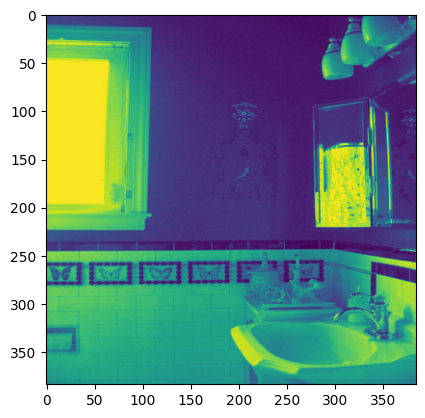

In [22]:
import matplotlib.pyplot as plt
plt.imshow(training_dataset[0]["image"][0])

In [10]:
def setup_ddp(rank, world_size):
    """Initialize DDP environment"""
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    
    # Initialize process group
    dist.init_process_group(
        backend='nccl',
        init_method='env://',
        world_size=world_size,
        rank=rank
    )
    
    # Set device for this process
    torch.cuda.set_device(rank)


def cleanup_ddp():
    """Clean up DDP"""
    dist.destroy_process_group()

In [ ]:
def train_blip_ddp(
    rank,
    world_size,
    train_json,
    train_image_root,
    val_json,
    val_image_root,
    output_dir,
    num_epochs=10,
    batch_size=16,
    learning_rate=1e-4,
    checkpoint_interval_mins=30,
    checkpoint_fraction=0.25,
    num_workers=4,
    resume=False
):
    """Training function for each DDP process"""
    
    # Setup DDP
    setup_ddp(rank, world_size)
    
    is_main_process = (rank == 0)
    device = torch.device(f'cuda:{rank}')
    
    if is_main_process:
        print("=" * 80)
        print(f"🚀 BLIP Training Configuration (DDP)")
        print("=" * 80)
        print(f"World Size (GPUs): {world_size}")
        print(f"Batch Size (per GPU): {batch_size}")
        print(f"Effective Batch Size: {batch_size * world_size}")
        print(f"Learning Rate: {learning_rate}")
        print(f"Epochs: {num_epochs}")
        print(f"Checkpoint Interval: {checkpoint_interval_mins} mins or {checkpoint_fraction} epoch")
        print(f"Resume from checkpoint: {resume}")
        print("=" * 80)
    
    # Initialize logger (only on main process)
    if is_main_process:
        log_dir = os.path.join(output_dir, 'logs')
        logger = TrainingLogger(log_dir, resume=resume)
        logger.print_summary("Training started with DDP")
        
        checkpoint_manager = CheckpointManager(
            output_dir, 
            save_interval_mins=checkpoint_interval_mins,
            save_fraction=checkpoint_fraction
        )
    else:
        logger = None
        checkpoint_manager = None
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset
    train_dataset = COCOCaptionDataset(train_json, train_image_root, transform, tokenizer)
    
    # DDP Sampler (ensures each GPU gets different data)
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=world_size,
        rank=rank,
        shuffle=True,
        drop_last=False
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler,  # Use DDP sampler instead of shuffle
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )
    
    if is_main_process:
        logger.print_summary(f"Dataset loaded: {len(train_dataset)} samples, {len(train_loader)} batches per GPU")
    
    # Initialize model
    model = BLIPModel().to(device)
    
    # Wrap with DDP
    model = nn.parallel.DistributedDataParallel(
        model,
        device_ids=[rank],
        output_device=rank,
        find_unused_parameters=False  # Set True if you have unused params
    )
    
    if is_main_process:
        logger.print_summary(f"Using DistributedDataParallel across {world_size} GPUs")
    
    # Optimizer (only trainable parameters)
    optimizer = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate,
        betas=(0.9, 0.98),
        weight_decay=0.05
    )
    
    # Cosine learning rate scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    
    # Initialize interrupt handler (only on main process)
    if is_main_process:
        interrupt_handler = GracefulInterruptHandler(
            checkpoint_manager, model, optimizer, scheduler, logger
        )
    
    # Resume from checkpoint if requested
    start_epoch = 0
    start_batch = 0
    global_step = 0
    
    if resume and is_main_process:
        latest_checkpoint = checkpoint_manager.get_latest_checkpoint()
        if latest_checkpoint:
            logger.print_summary(f"Resuming from checkpoint: {latest_checkpoint}")
            # Load on main process, then broadcast will sync to other processes
            model_to_load = model.module  # Unwrap DDP
            state = checkpoint_manager.load_checkpoint(model_to_load, optimizer, scheduler, latest_checkpoint)
            start_epoch = state['epoch']
            start_batch = state['batch']
            global_step = state['global_step']
            logger.print_summary(f"Resumed at epoch {start_epoch}, batch {start_batch}, step {global_step}")
        else:
            logger.print_summary("No checkpoint found, starting from scratch")
    
    # Broadcast start_epoch, start_batch, global_step to all processes
    if world_size > 1:
        start_info = torch.tensor([start_epoch, start_batch, global_step], dtype=torch.long, device=device)
        dist.broadcast(start_info, src=0)
        if rank != 0:
            start_epoch, start_batch, global_step = start_info.tolist()
    
    # Training loop
    training_start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        
        # Set epoch for sampler (important for proper shuffling)
        train_sampler.set_epoch(epoch)
        
        epoch_start_time = time.time()
        
        # Accumulators for epoch metrics (only on main process)
        if is_main_process:
            epoch_loss_total = 0
            epoch_loss_itc = 0
            epoch_loss_itm = 0
            epoch_loss_lm = 0
            num_batches = 0
        
        # Progress bar (only on main process)
        if is_main_process:
            pbar = tqdm(
                enumerate(train_loader), 
                total=len(train_loader),
                desc=f"Epoch {epoch+1}/{num_epochs}",
                initial=start_batch if epoch == start_epoch else 0
            )
        else:
            pbar = enumerate(train_loader)
        
        batch_start_time = time.time()
        
        for batch_idx, batch in pbar:
            # Skip batches if resuming
            if epoch == start_epoch and batch_idx < start_batch:
                continue
            
            data_time = time.time() - batch_start_time
            
            # Move to device
            image = batch['image'].to(device, non_blocking=True)
            text_input_ids = batch['text_input_ids'].to(device, non_blocking=True)
            text_attention_mask = batch['text_attention_mask'].to(device, non_blocking=True)
            decoder_input_ids = batch['decoder_input_ids'].to(device, non_blocking=True)
            decoder_attention_mask = batch['decoder_attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            # Forward pass
            loss_itc, loss_itm, loss_lm = model(
                image,
                text_input_ids,
                text_attention_mask,
                decoder_input_ids,
                decoder_attention_mask,
                labels
            )
            
            # Total loss
            loss = loss_itc + loss_itm + loss_lm
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            batch_time = time.time() - batch_start_time
            global_step += 1
            
            # Gather metrics from all GPUs (only on main process)
            if is_main_process:
                epoch_loss_total += loss.item()
                epoch_loss_itc += loss_itc.item()
                epoch_loss_itm += loss_itm.item()
                epoch_loss_lm += loss_lm.item()
                num_batches += 1
                
                # Get memory stats
                memory_allocated = torch.cuda.memory_allocated(device) / 1e9
                memory_reserved = torch.cuda.memory_reserved(device) / 1e9
                
                # Log batch metrics
                batch_metrics = {
                    'epoch': epoch + 1,
                    'batch': batch_idx + 1,
                    'global_step': global_step,
                    'loss_total': loss.item(),
                    'loss_itc': loss_itc.item(),
                    'loss_itm': loss_itm.item(),
                    'loss_lm': loss_lm.item(),
                    'lr': optimizer.param_groups[0]['lr'],
                    'batch_time': batch_time,
                    'data_time': data_time,
                    'memory_allocated_gb': memory_allocated,
                    'memory_reserved_gb': memory_reserved
                }
                logger.log_batch(batch_metrics)
                
                # Update interrupt handler state
                interrupt_handler.update_state(
                    epoch + 1, batch_idx + 1, global_step,
                    {'loss_total': loss.item(), 'loss_itc': loss_itc.item(), 
                     'loss_itm': loss_itm.item(), 'loss_lm': loss_lm.item()}
                )
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'itc': f"{loss_itc.item():.4f}",
                    'itm': f"{loss_itm.item():.4f}",
                    'lm': f"{loss_lm.item():.4f}",
                    'lr': f"{optimizer.param_groups[0]['lr']:.2e}",
                    'mem': f"{memory_allocated:.2f}GB"
                })
                
                # Check if we should save checkpoint
                elapsed_since_last_save = (time.time() - checkpoint_manager.last_save_time) / 60
                if checkpoint_manager.should_save(batch_idx + 1, len(train_loader), elapsed_since_last_save):
                    checkpoint_manager.save_checkpoint(
                        model.module,  # Unwrap DDP
                        optimizer, scheduler,
                        epoch + 1, batch_idx + 1, global_step,
                        batch_metrics,
                        logger,
                        checkpoint_type='auto'
                    )
            
            batch_start_time = time.time()
        
        # Epoch summary (only on main process)
        if is_main_process:
            epoch_time = (time.time() - epoch_start_time) / 60
            avg_loss_total = epoch_loss_total / num_batches
            avg_loss_itc = epoch_loss_itc / num_batches
            avg_loss_itm = epoch_loss_itm / num_batches
            avg_loss_lm = epoch_loss_lm / num_batches
            samples_per_sec = (len(train_dataset) / world_size) / (epoch_time * 60)  # Per GPU
            
            # Log epoch metrics
            epoch_metrics = {
                'epoch': epoch + 1,
                'avg_loss_total': avg_loss_total,
                'avg_loss_itc': avg_loss_itc,
                'avg_loss_itm': avg_loss_itm,
                'avg_loss_lm': avg_loss_lm,
                'epoch_time_mins': epoch_time,
                'samples_per_sec': samples_per_sec * world_size,  # Total throughput
                'lr': optimizer.param_groups[0]['lr']
            }
            logger.log_epoch(epoch_metrics)
            
            # Print epoch summary
            logger.print_summary(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            logger.print_summary(f"  Time: {epoch_time:.2f} mins")
            logger.print_summary(f"  Avg Loss: {avg_loss_total:.4f}")
            logger.print_summary(f"  Avg ITC: {avg_loss_itc:.4f}")
            logger.print_summary(f"  Avg ITM: {avg_loss_itm:.4f}")
            logger.print_summary(f"  Avg LM: {avg_loss_lm:.4f}")
            logger.print_summary(f"  Throughput: {samples_per_sec * world_size:.2f} samples/sec (total)")
            logger.print_summary(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
            
            # Save end-of-epoch checkpoint
            checkpoint_manager.save_checkpoint(
                model.module,  # Unwrap DDP
                optimizer, scheduler,
                epoch + 1, 0, global_step,
                epoch_metrics,
                logger,
                checkpoint_type='epoch_end'
            )
        
        # Reset start_batch for next epoch
        start_batch = 0
        
        # Synchronize all processes before next epoch
        dist.barrier()
    
    # Training complete
    if is_main_process:
        total_training_time = (time.time() - training_start_time) / 60
        logger.print_summary(f"\n{'='*80}")
        logger.print_summary(f"✓ Training Complete!")
        logger.print_summary(f"  Total Time: {total_training_time:.2f} mins ({total_training_time/60:.2f} hours)")
        logger.print_summary(f"  Total Steps: {global_step}")
        logger.print_summary(f"  Logs saved to: {log_dir}")
        logger.print_summary(f"  Checkpoints saved to: {output_dir}")
        logger.print_summary(f"{'='*80}\n")
    
    # Cleanup
    cleanup_ddp()

In [ ]:
def train_blip(
    train_json,
    train_image_root,
    val_json,
    val_image_root,
    output_dir,
    num_epochs=10,
    batch_size=16,
    learning_rate=1e-4,
    device='cuda',
    resume=False,
    checkpoint_interval_mins=30,
    checkpoint_fraction=0.25,
    num_workers=4
):
    """Wrapper function to launch DDP training"""
    
    # Check if multi-GPU
    world_size = torch.cuda.device_count()
    
    if world_size > 1:
        print(f"Launching DDP training on {world_size} GPUs...")
        
        # Spawn processes for DDP
        mp.spawn(
            train_blip_ddp,
            args=(
                world_size,
                train_json,
                train_image_root,
                val_json,
                val_image_root,
                output_dir,
                num_epochs,
                batch_size,
                learning_rate,
                checkpoint_interval_mins,
                checkpoint_fraction,
                num_workers,
                resume
            ),
            nprocs=world_size,
            join=True
        )
    else:
        # Single GPU training
        print("Single GPU training...")
        train_blip_ddp(
            rank=0,
            world_size=1,
            train_json=train_json,
            train_image_root=train_image_root,
            val_json=val_json,
            val_image_root=val_image_root,
            output_dir=output_dir,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            checkpoint_interval_mins=checkpoint_interval_mins,
            checkpoint_fraction=checkpoint_fraction,
            num_workers=num_workers,
            resume=resume
        )